# Churn Prediction

## Importing libraries

In [35]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import lightgbm as lgb
import mlflow

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn import set_config
set_config(display='diagram')

from typing import List
from typing import Dict

## Setup MLFlow

In [36]:
mlflow.get_tracking_uri()

'file:///home/nsboan/projetos/mlflow-pydata-talk/mlruns'

In [37]:
mlflow.set_tracking_uri('file:///home/nsboan/projetos/mlflow-pydata-talk/mlruns')

In [38]:
mlflow_exp = mlflow.set_experiment('churn-classification-nsb')

## Loading Data

In [39]:
df = pd.read_csv('../data/raw/customer_churn_dataset-training-master.csv')
display(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440833 entries, 0 to 440832
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         440832 non-null  float64
 1   Age                440832 non-null  float64
 2   Gender             440832 non-null  object 
 3   Tenure             440832 non-null  float64
 4   Usage Frequency    440832 non-null  float64
 5   Support Calls      440832 non-null  float64
 6   Payment Delay      440832 non-null  float64
 7   Subscription Type  440832 non-null  object 
 8   Contract Length    440832 non-null  object 
 9   Total Spend        440832 non-null  float64
 10  Last Interaction   440832 non-null  float64
 11  Churn              440832 non-null  float64
dtypes: float64(9), object(3)
memory usage: 40.4+ MB


None

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.000,30.000,Female,39.000,14.000,5.000,18.000,Standard,Annual,932.000,17.000,1.000
1,3.000,65.000,Female,49.000,1.000,10.000,8.000,Basic,Monthly,557.000,6.000,1.000
2,4.000,55.000,Female,14.000,4.000,6.000,18.000,Basic,Quarterly,185.000,3.000,1.000
3,5.000,58.000,Male,38.000,21.000,7.000,7.000,Standard,Monthly,396.000,29.000,1.000
4,6.000,23.000,Male,32.000,20.000,5.000,8.000,Basic,Monthly,617.000,20.000,1.000


## Validating Data

* <code>CustomerID</code>must be unique
* <code>Age</code> must be non-negative
* <code>Age</code> can't go above 100
* <code>Gender</code> must be one of ['Male', 'Female']
* <code>Usage Frequency</code> must be non-negative
* <code>Support Calls</code> must be non-negative
* <code>Payment Delay</code> must be non-negative
* <code>Subscription Type</code> must be one of ['Standard', 'Basic', 'Premium']
* <code>Contract Length</code> must be one of ['Annual', 'Monthly', 'Quarterly']
* <code>Total Spend</code> must be non-negative
* <code>Last Interaction</code> must be non-negative
* <code>Churn</code> must be one of [1.0, 0.0]

In [40]:
def check_non_negative(data: pd.core.frame.DataFrame, ls_columns: List[str]) -> Dict[str,bool]:
    
    results = {column:False for column in ls_columns}
    
    for column in ls_columns:
        if not data[column].min() >= 0:
            results[column] = True

    return results

def valid_value_of_list(data: pd.core.frame.DataFrame, ls_columns: List[str], rules_ls: Dict[str,list]) -> Dict[str,bool]:
    
    results = {column:False for column in ls_columns}
    
    for column in ls_columns:
        results[column] = all(df[column].isin(rules_ls[column]))
        
        if not results[column]:
            results[column] = [False,set(df[column]).symmetric_difference(rules_ls[column])]
        
    return results

In [41]:
check_non_negative(df, ['Age','Usage Frequency','Support Calls','Payment Delay','Total Spend','Last Interaction'])

{'Age': False,
 'Usage Frequency': False,
 'Support Calls': False,
 'Payment Delay': False,
 'Total Spend': False,
 'Last Interaction': False}

In [42]:
valid_value_of_list(df, ['Gender','Subscription Type','Subscription Type','Contract Length','Churn'],
                    {'Gender':['Male', 'Female'],
                     'Subscription Type':['Standard', 'Basic', 'Premium'],
                     'Contract Length':['Annual', 'Monthly', 'Quarterly'],
                     'Churn':[1.0,0.0]
                    })

{'Gender': [False, {nan}],
 'Subscription Type': [False, {nan}],
 'Contract Length': [False, {nan}],
 'Churn': [False, {nan}]}

In [43]:
df.CustomerID.value_counts(ascending=False)

CustomerID
2.000         1
301011.000    1
301009.000    1
301008.000    1
301007.000    1
             ..
151752.000    1
151751.000    1
151750.000    1
151749.000    1
449999.000    1
Name: count, Length: 440832, dtype: int64

In [44]:
df.Age.max()

65.0

In [45]:
print(df.shape)
df.dropna(how='any',inplace=True)
print(df.shape)

(440833, 12)
(440832, 12)


## EDA

In [46]:
df.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.000,30.000,Female,39.000,14.000,5.000,18.000,Standard,Annual,932.000,17.000,1.000
1,3.000,65.000,Female,49.000,1.000,10.000,8.000,Basic,Monthly,557.000,6.000,1.000
2,4.000,55.000,Female,14.000,4.000,6.000,18.000,Basic,Quarterly,185.000,3.000,1.000
3,5.000,58.000,Male,38.000,21.000,7.000,7.000,Standard,Monthly,396.000,29.000,1.000
4,6.000,23.000,Male,32.000,20.000,5.000,8.000,Basic,Monthly,617.000,20.000,1.000


In [47]:
df.columns = [x.lower().replace(' ', '_') for x in df.columns]

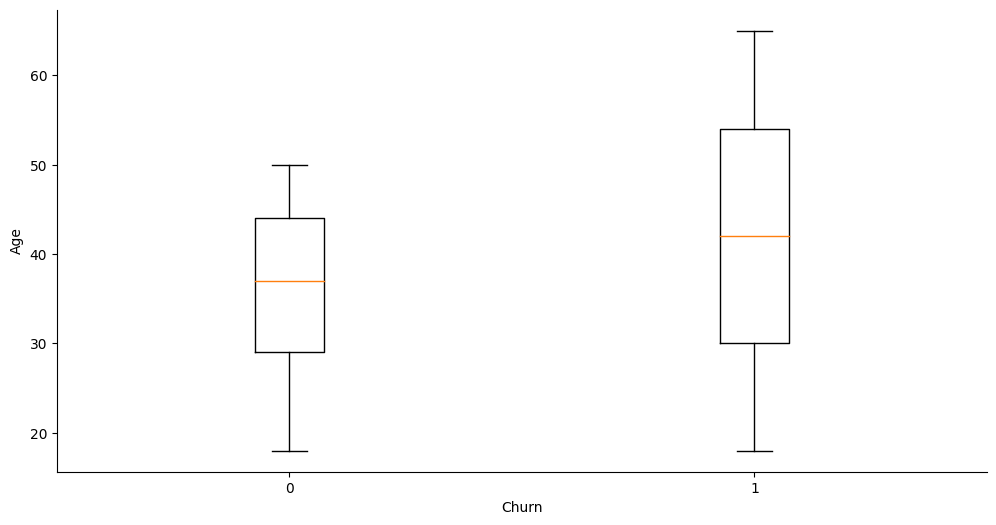

In [48]:
f_boxplot, ax = plt.subplots(figsize=(12,6))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('Churn')
ax.set_ylabel('Age')

ax.boxplot(df.query("churn == 0").age, positions=[0])
ax.boxplot(df.query("churn == 1").age, positions=[1])

plt.show()

<Axes: xlabel='churn', ylabel='count'>

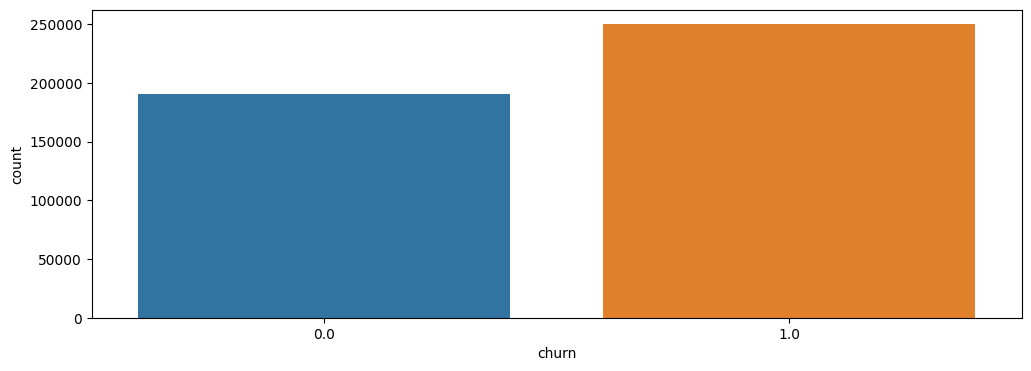

In [49]:
f_count_labels, ax = plt.subplots(figsize=(12,4))

sns.countplot(df, x='churn')

<Axes: xlabel='payment_bin', ylabel='sup_bin'>

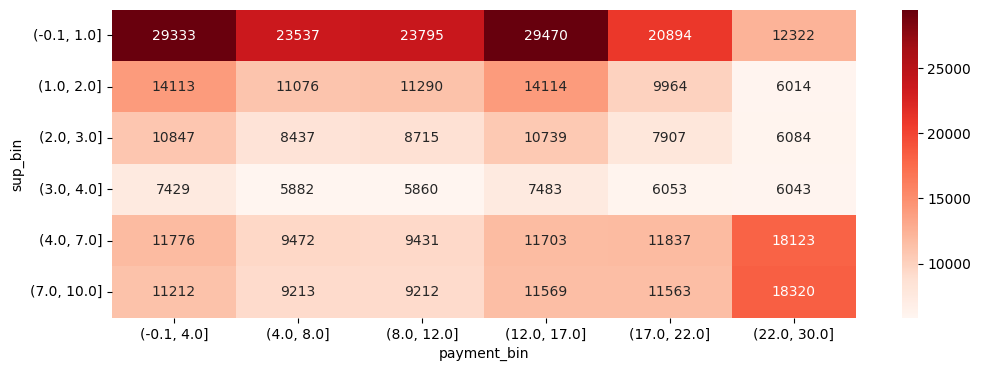

In [50]:
f_heatmap, ax = plt.subplots(figsize=(12,4))

(
    df
    .loc[:,['support_calls','payment_delay']]
    .assign(sup_bin = lambda x: pd.qcut(x.support_calls, q=6, precision=1))
    .assign(payment_bin = lambda x: pd.qcut(x.payment_delay, q=6, precision=1))
    .pivot_table(index='sup_bin', columns='payment_bin', values='support_calls', aggfunc='count')
    .pipe((sns.heatmap,'data'), annot=True, ax=ax, fmt='.0f', cmap='Reds')
)

## Model development & evaluation

In [51]:
df.head()

,customerid,age,gender,tenure,usage_frequency,support_calls,payment_delay,subscription_type,contract_length,total_spend,last_interaction,churn
0,2.000,30.000,Female,39.000,14.000,5.000,18.000,Standard,Annual,932.000,17.000,1.000
1,3.000,65.000,Female,49.000,1.000,10.000,8.000,Basic,Monthly,557.000,6.000,1.000
2,4.000,55.000,Female,14.000,4.000,6.000,18.000,Basic,Quarterly,185.000,3.000,1.000
3,5.000,58.000,Male,38.000,21.000,7.000,7.000,Standard,Monthly,396.000,29.000,1.000
4,6.000,23.000,Male,32.000,20.000,5.000,8.000,Basic,Monthly,617.000,20.000,1.000


In [52]:
cat_cols = ['gender','subscription_type','contract_length']
num_cols = ['age', 'tenure', 'usage_frequency', 
            'support_calls', 'payment_delay', 'total_spend', 
            'last_interaction']

In [53]:
model = (
    make_pipeline(
        make_column_transformer((OneHotEncoder(), cat_cols),(MinMaxScaler(), num_cols)),
        lgb.LGBMClassifier()
    )
)

model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['gender',
                                                   'subscription_type',
                                                   'contract_length']),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['age', 'tenure',
                                                   'usage_frequency',
                                                   'support_calls',
                                                   'payment_delay',
                                                   'total_spend',
                                                   'last_interaction'])])),
                ('lgbmclassifier', LGBMClassifier())])

In [54]:
df_train, df_val = train_test_split(df.drop('customerid',axis=1), test_size=0.2, random_state=42)

[LightGBM] [Info] Number of positive: 199895, number of negative: 152770
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 481
[LightGBM] [Info] Number of data points in the train set: 352665, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.566813 -> initscore=0.268859
[LightGBM] [Info] Start training from score 0.268859


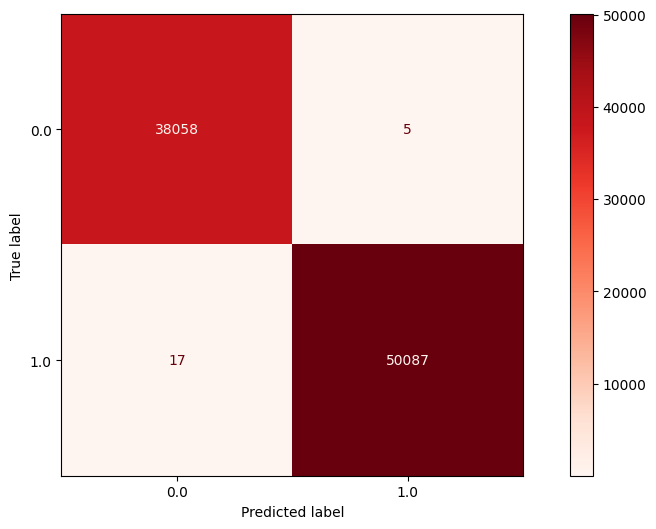

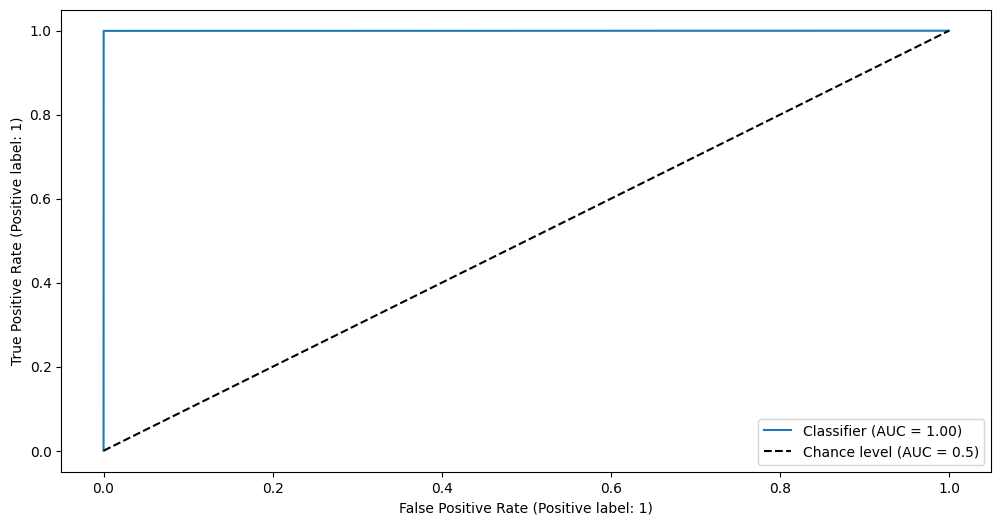

In [55]:
exp_tags = {
    'main-model':'lgbm',
    'task':'classification',
    'bp':'churn prediction'
}

with mlflow.start_run(tags=exp_tags):

    ## logging EDA figures
    mlflow.log_figure(f_count_labels,'class_counts.png')
    mlflow.log_figure(f_boxplot,'age_class_distribution.png')
    mlflow.log_figure(f_heatmap,'support_and_payment_bins.png')
    
    ## autologging the model
    mlflow.lightgbm.autolog(log_input_examples=True)
    model.fit(df_train.drop('churn', axis=1), df_train.churn)

    y_pred = model.predict(df_val.drop('churn', axis=1))

    ## creating and logging the confusion matrix plot
    f_confusion, ax = plt.subplots(figsize=(12,6))
    ConfusionMatrixDisplay.from_predictions(df_val.churn, y_pred, 
                                            cmap='Reds', 
                                            ax=ax,
                                            values_format='.0f')
    mlflow.log_figure(f_confusion, 'eval_confusion_matrix.png')

    ## creating and logging the ROC AUC CURVE
    f_roc, ax = plt.subplots(figsize=(12,6))
    RocCurveDisplay.from_predictions(df_val.churn,
                                     y_pred,
                                     plot_chance_level=True,
                                     ax=ax)
    
    mlflow.log_figure(f_roc, 'eval_roc_auc_curve.png')
    
    ## logging eval_metrics
    acc = accuracy_score(df_val.churn, y_pred)
    roc_auc = roc_auc_score(df_val.churn, y_pred)
    prec = precision_score(df_val.churn, y_pred)
    f1 = f1_score(df_val.churn, y_pred)
    rec = recall_score(df_val.churn, y_pred)

    metrics = {'accuracy':acc,
              'roc_auc_score':roc_auc,
              'pos_class_precision':prec,
              'pos_class_recall':rec,
              'pos_class_f1':f1}
    
    mlflow.log_metrics(metrics)

In [183]:
model.fit(df_train.drop('churn', axis=1), df_train.churn)

[LightGBM] [Info] Number of positive: 199895, number of negative: 152770
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 481
[LightGBM] [Info] Number of data points in the train set: 352665, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.566813 -> initscore=0.268859
[LightGBM] [Info] Start training from score 0.268859


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['gender',
                                                   'subscription_type',
                                                   'contract_length']),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['age', 'tenure',
                                                   'usage_frequency',
                                                   'support_calls',
                                                   'payment_delay',
                                                   'total_spend',
                                                   'last_interaction'])])),
                ('lgbmclassifier', LGBMClassifier())])

In [184]:
y_pred = model.predict(df_val.drop('churn', axis=1))

NameError: name 'df_val' is not defined

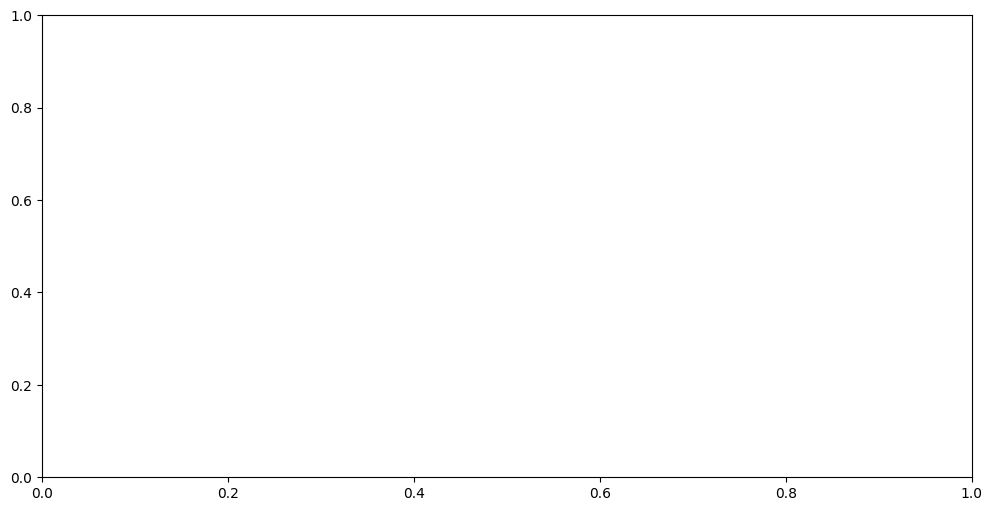

In [29]:
f_confusion, ax = plt.subplots(figsize=(12,6))

ConfusionMatrixDisplay.from_predictions(df_val.churn, y_pred)

In [28]:
disp = ConfusionMatrixDisplay(confusion_matrix(df_val.churn, y_pred))
disp.plot(cmap='Reds', values_format='.0f')

NameError: name 'df_val' is not defined

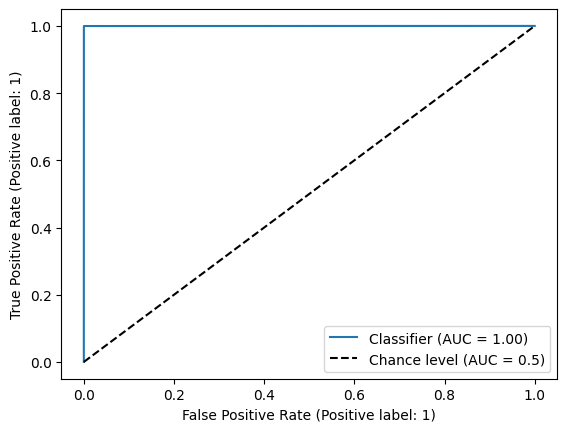

In [186]:
RocCurveDisplay.from_predictions(df_val.churn, 
                                 y_pred,
                                plot_chance_level=True)

In [187]:
print(classification_report(df_val.churn, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     38063
         1.0       1.00      1.00      1.00     50104

    accuracy                           1.00     88167
   macro avg       1.00      1.00      1.00     88167
weighted avg       1.00      1.00      1.00     88167



## Evaluation on testing dataset

In [189]:
df_test = (
    pd.read_csv('../data/raw/customer_churn_dataset-testing-master.csv')
    .drop('CustomerID', axis=1)
)

df_test.columns = [x.lower().replace(' ', '_') for x in df_test.columns]

In [197]:
y_pred_test = model.predict(df_test.drop('churn', axis=1))

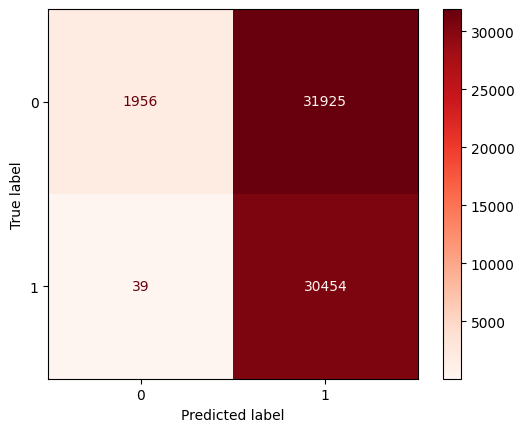

In [198]:
disp = ConfusionMatrixDisplay(confusion_matrix(df_test.churn, y_pred_test))
disp.plot(cmap='Reds', values_format='.0f')

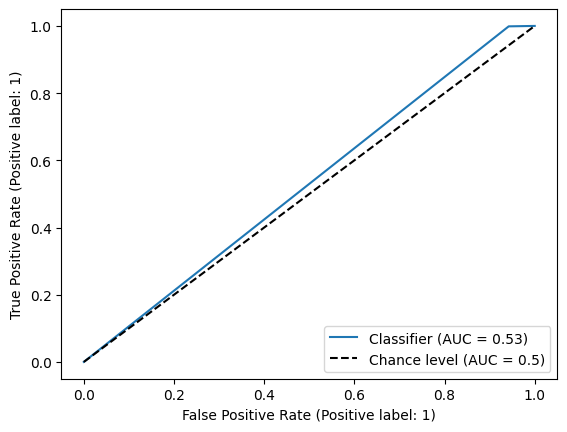

In [199]:
RocCurveDisplay.from_predictions(df_test.churn, 
                                 y_pred_test,
                                plot_chance_level=True)

In [201]:
print(classification_report(df_test.churn, y_pred_test))

              precision    recall  f1-score   support

           0       0.98      0.06      0.11     33881
           1       0.49      1.00      0.66     30493

    accuracy                           0.50     64374
   macro avg       0.73      0.53      0.38     64374
weighted avg       0.75      0.50      0.37     64374

